In [ ]:
!pip install jsonlines pandas matplotlib nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
path_test = r'./dataset/test_diplomacy.jsonl'
path_train = r'./dataset/train_diplomacy.jsonl'
path_validation = r'./dataset/validation_diplomacy.jsonl'

In [ ]:
def load_data(dataset):
    with jsonlines.open(dataset, 'r') as reader:
        data = list(reader)
        list_messages = []
        list_labels = []
        for line in data:
            list_messages.extend(line['messages'])
            list_labels.extend(line['sender_labels'])
    dict_out = {'messages': list_messages, 'label': list_labels}
    df = pd.DataFrame(dict_out)
    return df

In [ ]:
%cd   /content/drive/MyDrive/prueba_tenica_BC/
!ls

/content/drive/MyDrive/prueba_tenica_BC
bert_ds  dataset  EDA.ipynb  model_train  train_model.ipynb  train_tf_smallBert.ipynb


In [ ]:
!pwd

/content/drive/MyDrive/prueba_tenica_BC


In [ ]:
test=load_data(path_test)
train = load_data(path_train)
validation = load_data(path_validation)

### validar nulos en el DF

In [ ]:
na_test = test[test.isna().any(axis=1)]
na_train = train[train.isna().any(axis=1)]
na_vali = validation[validation.isna().any(axis=1)]

print("cantidad de datos vacios de entrenamiento" ,na_train.shape[0])
print("cantidad de datos vacios de validacion" ,na_vali.shape[0])
print("cantidad de datos vacios de test" ,na_test.shape[0])

cantidad de datos vacios de entrenamiento 0
cantidad de datos vacios de validacion 0
cantidad de datos vacios de test 0


### Limpieza de stopwords y mensajes menor a 10 caracteres

In [ ]:
def clean_text(t):
    tl = []
    t = t.lower().split()
    for i in t:
        if i not in stopwords.words('english'):
            tl.append(i)
    return " ".join(tl)

In [ ]:
def all_clean(dataset, column):
    dataset[column] = dataset[column].apply((lambda x:re.sub('@[^\s]+','',x)))
    dataset[column] = dataset[column].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    text1 = dataset[column].apply(lambda x: clean_text(x))
    return text1

In [ ]:
def all_clean_dataset(dataset, column):
    dataset[column] = dataset[column].apply((lambda x:re.sub('@[^\s]+','',x)))
    dataset[column] = dataset[column].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    dataset[column] = dataset[column].apply(lambda x: clean_text(x))
    return dataset

In [ ]:
train = all_clean_dataset(train,'messages')
test = all_clean_dataset(test,'messages')
validation = all_clean_dataset(validation,'messages')

Eliminación de texto menos a 10 caracteres


In [ ]:
train = train[train['messages'].str.len()>=10]
validation = validation[validation['messages'].str.len()>=10]

#### validación de longitud para conjunto de train

In [ ]:
train_false= train[train['label']==False]
train_true= train[train['label']==True]

In [ ]:
train_false.shape

(556, 2)

In [ ]:
# serie_true = all_clean(train_true,'messages')
# serie_false = all_clean(train_false,'messages')

In [ ]:
# dim_true = serie_true.str.split().str.len()
# dim_false = serie_false.str.split().str.len()

### Utilicese solo para el Undersampling

Acá es donde se descartan muestras de la clase mayoritaria

In [ ]:
train_true_und = train_true.copy()
train_true_und['lenght'] = train_true_und['messages'].str.split().str.len()

In [ ]:
train_true_und_sld = train_true_und[(train_true_und['lenght'] <= 25) & (train_true_und['label'] == True)]
train_true_und_sld.shape[0]

10487

In [ ]:
dim_true = train_true_und_sld['messages'].str.split().str.len()
dim_false = train_false['messages'].str.split().str.len()

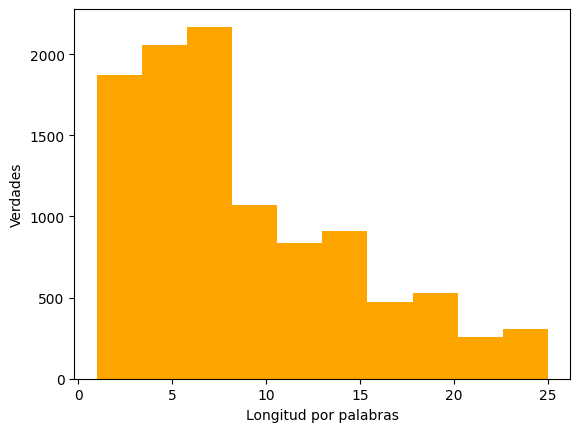

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_true,color='orange')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("Verdades")
plt.show()

In [ ]:
dim_true.describe()

count    10487.000000
mean         8.794984
std          5.750579
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         25.000000
Name: messages, dtype: float64

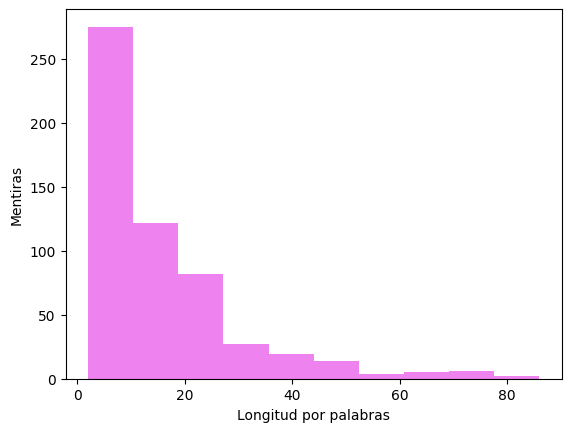

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_false,color='violet')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("Mentiras")
plt.show()

In [ ]:
dim_false.describe()

count    556.000000
mean      15.516187
std       14.286821
min        2.000000
25%        6.000000
50%       11.000000
75%       20.000000
max       86.000000
Name: messages, dtype: float64

In [ ]:
dim_true[dim_true>25].shape

(0,)

### Se define un método de exportación en el cual se deja un txt por clase y una carpeta por cada conjunto del dataset

In [ ]:
train_true['lenght'] = train_true['messages'].str.split().str.len()
train_true = train_true[(train_true['lenght'] <= 10)]
train_true.shape[0]

7167

In [ ]:
train_new_true = train_true[['messages','label']]
train_new_true

,messages,label
1,youve whet appetite italy whats suggestion,True
7,sorry italy ive away um german things brewing ...,True
16,france tell moving burgundy stab,True
19,okay thanks telling,True
20,um alliance,True
...,...,...
13124,dont know im little annoyed,True
13126,guess see happens,True
13127,way actually ending conflict,True
13128,agree peace demands,True


In [ ]:
new_train = pd.concat([train_new_true, train_false], axis=0)

In [ ]:
new_train = new_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_train[new_train['label']==False]

,messages,label
1,hi england looked map reassessed alliances yea...,False
95,sir terrific ally needed makes feel like reall...,False
98,would suggest bre wal pic wal pic channel conv...,False
164,taking mos,False
184,nothing worth telling want attack russia cours...,False
...,...,...
7699,haha alright ill keep abrest france move fleet...,False
7705,hes asked many times best way attack setting t...,False
7711,hey think agree need take whatever measures po...,False
7717,move attack france spring like think mobilizin...,False


### formato de exorte de textos a carpetas

In [ ]:
def creator_text(data_frame,path):
  for sample in data_frame.index:
    index = sample
    with open(path + 'text_' + str(index) + '.txt', 'w') as f:
        f.write(data_frame['messages'][index])

  return print("Create all samples on " , path)

In [ ]:
path_train_true = r'./dataset/bert_un_sp/train/True/'
path_train_false = r'./dataset/bert_un_sp/train/False/'

path_val_true = r'./dataset/bert_un_sp/val/True/'
path_val_false = r'./dataset/bert_un_sp/val/False/'

path_test_true = r'./dataset/bert_un_sp/test/True/'
path_test_false = r'./dataset/bert_un_sp/test/False/'

In [ ]:
creator_text(test[test['label']==True],path_test_true)
creator_text(test[test['label']==False],path_test_false)
creator_text(new_train[new_train['label']==True],path_train_true)
creator_text(new_train[new_train['label']==False],path_train_false)
creator_text(validation[validation['label']==True],path_val_true)
creator_text(validation[validation['label']==False],path_val_false)

Create all samples on  ./dataset/bert_un_sp/test/True/
Create all samples on  ./dataset/bert_un_sp/test/False/
Create all samples on  ./dataset/bert_un_sp/train/True/
Create all samples on  ./dataset/bert_un_sp/train/False/
Create all samples on  ./dataset/bert_un_sp/val/True/
Create all samples on  ./dataset/bert_un_sp/val/False/


In [ ]:
import tensorflow as tf

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './dataset/bert_un_sp/train',
    batch_size=batch_size,
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7723 files belonging to 2 classes.
